In [1]:
import copy
import numpy as np

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import matplotlib.pyplot as plt
import librosa as lib
import IPython.display as ipd
from scipy.io.wavfile import write

from datasets import load_from_disk

from GREGOConfig import GREGOConfig
from model import AutoEncoder


c:\Users\marco\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Config

In [2]:
torch.cuda.is_available()

True

In [3]:
config = GREGOConfig()
print(config)

TransformerConfig:

Data:
+-----------------+
| batch_size : 18 |
+-----------------+

Model:
+--------------------+
| n_embed    : 216   |
| block_size : 216   |
| dropout    : 0.2   |
| bias       : 0     |
+--------------------+

Training Loop:
+-------------------+
| max_epochs : 1000 |
+-------------------+

AdamW Optimizer:
+-----------------------+
| learning_rate : 1e-05 |
+-----------------------+

System:
+---------------+
| device : cuda |
+---------------+



# Load the dataset

In [4]:
class DatasetCustom(Dataset):
    def __init__(self, dataset, device):
        self.dataset = dataset
        self.device = device

    def __getitem__(self, index):
        data = self.dataset[index]

        X = torch.tensor(np.reshape(data["X"], (config.block_size, config.n_embed)), dtype=torch.float32).to(self.device).unsqueeze(0)
        
        return {
            "X":X
                }
    
    def __len__(self) -> int :
        return self.dataset.num_rows

In [5]:
class DataLoaderFactory():
    def __init__(self, path:str = 'data/hugging_face_dataset/', batch_size = 3, device = 'cpu'):
        self.batch_size = batch_size
        self.device = device

        print("1. Loading dataset: ...", end="")        
        self.dataset = load_from_disk(path, keep_in_memory=True)
        print("\r1. Loading dataset: done ✔️")

        print("2. Preprocess datasets: ...", end="")
        train_validation_splits = self.dataset['train'].train_test_split(test_size=0.175)
        validation_test_splits = train_validation_splits['test'].train_test_split(test_size=0.15)
        print("\r2. Preprocess datasets: done ✔️")

        print("3. Split datasets: ...", end="")
        self.train_data = DatasetCustom(train_validation_splits['train'], self.device)
        self.val_data = DatasetCustom(validation_test_splits['train'], self.device)
        self.test_data = DatasetCustom(validation_test_splits['test'], self.device)
        print("\r3. Split datasets: done ✔️")

        self.dataloader_train = DataLoader(self.train_data, batch_size=batch_size, shuffle=True)
        self.dataloader_val = DataLoader(self.val_data, batch_size=batch_size, shuffle=True)
        self.dataloader_test = DataLoader(self.test_data, batch_size=batch_size, shuffle=True)

    def __len__(self) -> int :
        print("\033[95m\033[1m\033[4mNumber of data by datasets splits\033[0m")
        print(f"Train\t\t: {len(self.train_data)}\t\t-> {len(self.train_data)/self.batch_size}")
        print(f"Validation\t: {len(self.val_data)}\t\t-> {len(self.val_data)/self.batch_size}")
        print(f"Test\t\t: {len(self.test_data)}\t\t-> {len(self.test_data)/self.batch_size}")
        total = len(self.train_data) + len(self.val_data) + len(self.test_data)
        print(f"Total\t\t: {total}")
        return total

    def get_batch(self, split):
        # choose the correct dataloader
        if split == 'train':
            dataloader = self.dataloader_train
        elif split == 'val':
            dataloader = self.dataloader_val
        else:
            dataloader = self.dataloader_test

        for batch in dataloader:
            # Move tensors to device
            batch_on_device = {k: v for k, v in batch.items()}
            yield batch_on_device


# Model definition

In [6]:
class GREGO(nn.Module):
    def __init__(self,config):
        super(GREGO, self).__init__()
        
        
    def forward(self, x):
        return x

In [7]:
dataset = DataLoaderFactory(device=config.device, batch_size=config.batch_size)
batchs = dataset.get_batch('train')
len(dataset)

1. Loading dataset: done ✔️
2. Preprocess datasets: done ✔️
3. Split datasets: done ✔️
Number of data by datasets splits
Train		: 594		-> 33.0
Validation	: 107		-> 5.944444444444445
Test		: 19		-> 1.0555555555555556
Total		: 720


720

In [8]:
# Create an instance of the model, loss function and the optimizer
model = AutoEncoder(1)
model = model.to(torch.device(config.device))
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

# Training Loop

In [9]:
def training_loop(model, dataset, epoch):
    model = model.train()

    total_train_loss = 0.0
    batchs = dataset.get_batch('train')

    num_train_batches = len(dataset.train_data) // config.batch_size
    for i, batch in enumerate(batchs):
        # Get the batch data
        X = batch['X']
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        output = model(X)
        # Loss
        loss = criterion(output, X)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print loss (you might want to print every N batches, not every batch)
        print(f"\rEpoch [{epoch + 1}/{config.max_epochs}], Batch [{i}/{num_train_batches}], Loss: {loss.item()}", end="")

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / num_train_batches

    return model, avg_train_loss

# Validation Loop

In [10]:
def validation_loop(model, dataset, epoch):
    print(f"\nValidating...", end="")
    # Validation Evaluation
    model = model.eval()  # Set the model to evaluation mode

    total_val_loss = 0.0

    val_batches = dataset.get_batch('val')

    num_val_batches = len(dataset.val_data) // config.batch_size
    with torch.no_grad():  # Disable gradient computations
        for i, val_batch in enumerate(val_batches):
            # Get the batch data
            X = val_batch['X']
            # Forward pass
            val_outputs = model(X)
            # Compute loss

            val_loss = criterion(val_outputs, X)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / num_val_batches

    print(f"\rValidation Loss after Epoch {epoch + 1}: {avg_val_loss}\n")

    return avg_val_loss


In [11]:
# Early stopping parameters
patience = 5  # Number of epochs with no improvement after which training will be stopped
counter = 0  # To count number of epochs with no improvement
best_val_loss = None  # To keep track of best validation loss
best_model_state = None  # To store best model's state

train_losses = []
val_losses = []


for epoch in range(config.max_epochs):
    # training loop
    model, epoch_train_loss = training_loop(model, dataset, epoch)
    train_losses.append(epoch_train_loss)

    # validation loop
    epoch_val_loss = validation_loop(model, dataset, epoch)
    val_losses.append(epoch_val_loss)

    # Check if this epoch's validation loss is the best we've seen so far.
    if best_val_loss is None or epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_state = copy.deepcopy(model.state_dict())  # Save best model
        counter = 0  # Reset counter
    else:
        counter += 1  # Increment counter as no improvement in validation loss

    # If we've had patience number of epochs without improvement, stop training
    if counter >= patience:
        print(f"Early stopping on epoch {epoch}. Best epoch was {epoch - counter} with val loss: {best_val_loss:.4f}.")
        break

# Load best model weights
model.load_state_dict(best_model_state)
torch.save(model.state_dict(), 'out/best_model.pt')  # Save the best model to disk

Epoch [1/1000], Batch [32/33], Loss: 107.00213623046875
Validation Loss after Epoch 1: 123.70717315673828

Epoch [2/1000], Batch [32/33], Loss: 32.544250488281256
Validation Loss after Epoch 2: 102.5740753173828

Epoch [3/1000], Batch [32/33], Loss: 36.525012969970736
Validation Loss after Epoch 3: 79.87401542663574

Epoch [4/1000], Batch [32/33], Loss: 40.683784484863284
Validation Loss after Epoch 4: 68.95203399658203

Epoch [5/1000], Batch [32/33], Loss: 28.747156143188477
Validation Loss after Epoch 5: 51.5244857788086

Epoch [6/1000], Batch [32/33], Loss: 18.616077423095703
Validation Loss after Epoch 6: 48.839005851745604

Epoch [7/1000], Batch [32/33], Loss: 35.355014801025391
Validation Loss after Epoch 7: 38.54485168457031

Epoch [8/1000], Batch [32/33], Loss: 15.973357200622559
Validation Loss after Epoch 8: 36.658573913574216

Epoch [9/1000], Batch [32/33], Loss: 14.312616348266602
Validation Loss after Epoch 9: 33.31404895782471

Epoch [10/1000], Batch [32/33], Loss: 20.033

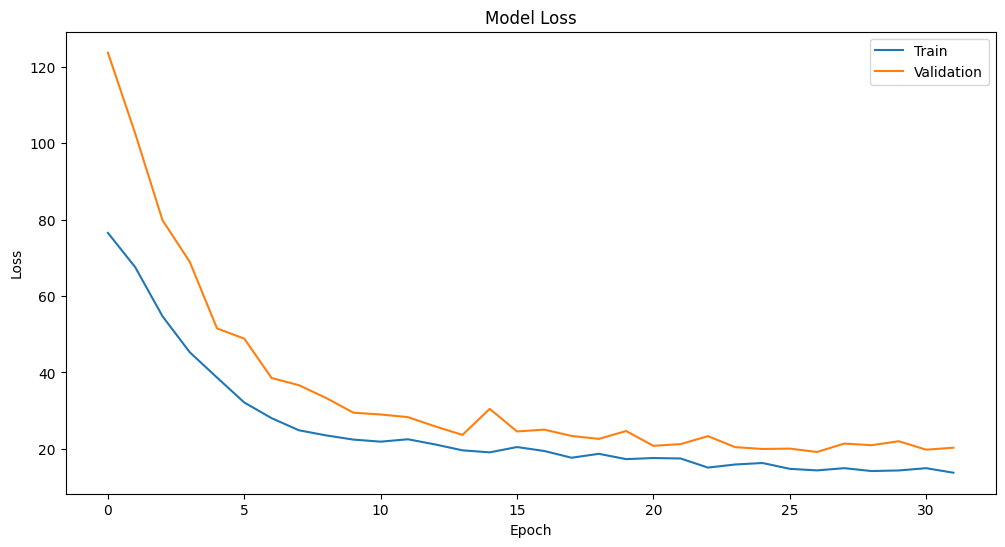

In [12]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))

plt.plot(train_losses)
plt.plot(val_losses)

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [13]:
exemple_batches = dataset.get_batch('train')
ex_batch = next(exemple_batches)
X = ex_batch['X']

In [14]:
# Trace the model
traced_model = torch.jit.trace(model.to('cpu'), (X.to('cpu')))
# Save the traced model
traced_model.save("out/best_model_script.pt")

In [15]:
batch = dataset.get_batch('test')
nb = next(batch)

In [16]:
loaded_model = torch.jit.load("out/best_model_script.pt").to(config.device)
loaded_model.eval()

RecursiveScriptModule(
  original_name=AutoEncoder
  (encoder): RecursiveScriptModule(
    original_name=Encoder
    (encoder): RecursiveScriptModule(
      original_name=ModuleList
      (0): RecursiveScriptModule(
        original_name=ConvDown
        (conv): RecursiveScriptModule(original_name=Conv2d)
        (norm): RecursiveScriptModule(original_name=BatchNorm2d)
        (dropout): RecursiveScriptModule(original_name=Dropout2d)
        (fc): RecursiveScriptModule(original_name=LeakyReLU)
      )
      (1): RecursiveScriptModule(
        original_name=ConvDown
        (conv): RecursiveScriptModule(original_name=Conv2d)
        (norm): RecursiveScriptModule(original_name=BatchNorm2d)
        (dropout): RecursiveScriptModule(original_name=Dropout2d)
        (fc): RecursiveScriptModule(original_name=LeakyReLU)
      )
      (2): RecursiveScriptModule(
        original_name=ConvDown
        (conv): RecursiveScriptModule(original_name=Conv2d)
        (norm): RecursiveScriptModule(origi

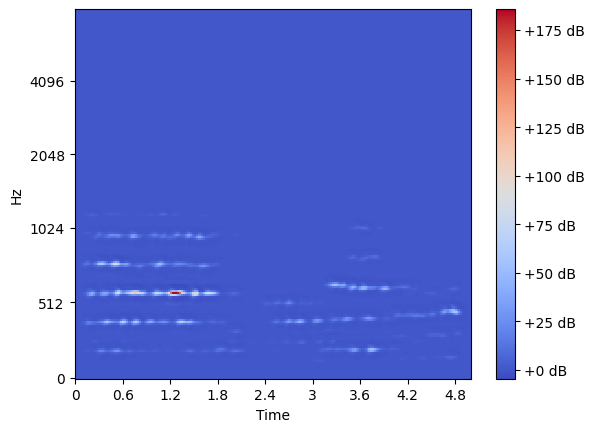

In [23]:
output = loaded_model(nb["X"] )

spec = output.detach().cpu().numpy()[1][0]

fig, ax = plt.subplots()
img = lib.display.specshow(spec, x_axis='time', y_axis='mel', sr=22050, fmax=8000, ax=ax)

ax.set(title="")
fig.colorbar(img,ax=[ax],format='%+2.0f dB')
plt.show()

In [18]:
def show_data(data,name,type):
    plt.figure()
    plt.title(f' {name}')
    plt.plot(data)
    if type == "time":
        plt.xlabel("N° sample")
        plt.ylabel("Magnitude")
    elif type == "mfcc":
        plt.xlabel("N° MFCC")
        plt.ylabel("Feature range")
    plt.show()

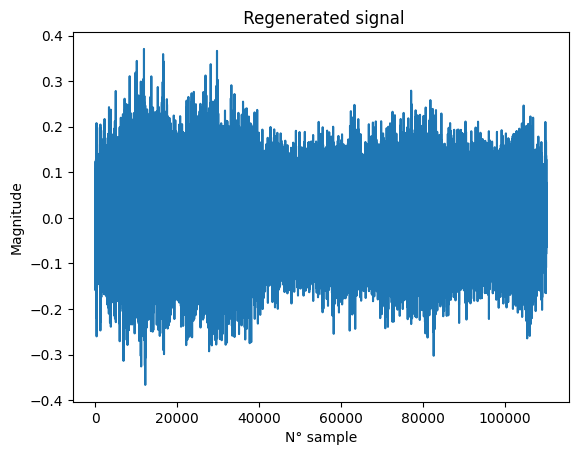

In [25]:
S_solo_wav_1 = lib.feature.inverse.mel_to_audio(spec,sr=22050)

show_data(S_solo_wav_1,"Regenerated signal","time")
ipd.Audio(S_solo_wav_1, rate=22050)

In [20]:
write("out.wav", 22050, np.array(S_solo_wav_1))